In [ ]:
# nlp
!conda install -c conda-forge bertopic
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# visualizations
!conda install -c conda-forge plotly nbconvert
!conda install -c conda-forge python-kaleido


In [4]:
import os, re, pickle
from bertopic import BERTopic
from tqdm import tqdm
from nltk.corpus import stopwords as stop_words
from datetime import datetime
from IPython.display import SVG, HTML, Image, display
import pandas as pd
import matplotlib.pyplot as plt
from scripts.publish_notebook import save_notebook_as_html

In [6]:
base_dir = "C:/Users/Boulanger/ownCloud/Langfristvorhaben/Legal-Theory-Graph/Data"
corpus_dir = os.path.join(base_dir, "FULLTEXTS/JLS/jls-txt")
d2y = pd.read_csv('data/jls-doi-to-year.csv')
stopwords=set(stop_words.words('english'))
stopwords.update({'jstor','conditions','terms','use','content','de','la','cit','yves','pm','tue','mon','wed','thu','fri','downloaded','jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'})

In [7]:
# Load the articles
if not os.path.exists('cache/jls-articles.pkl'):
    articles = []
    timestamps = []
    not_found = []
    for filename in tqdm(os.listdir(corpus_dir)):
        if filename.endswith(".txt"):
            with open(os.path.join(corpus_dir, filename), "r", encoding="utf-8") as f:
                article = f.read()
                tmp_article = []
                doi = filename.strip(".txt").replace("_","/")
                year = d2y.loc[d2y['DOI'] == doi, 'year']
                if year.empty:
                    year = d2y.loc[d2y['DOI'] == f"{doi}.x", 'year']
                # only use articles for which we have a year
                if not year.empty:
                    timestamp = datetime.strptime(str(year.values[0]), '%Y').date()
                    timestamps.append(timestamp)
                    for word in str(article).split():
                        # remove tokens containing numbers or those in the list of stopwords
                        if re.match(r'\d', word) is None and word.lower() not in stopwords:
                            tmp_article.append(word)
                    articles.append(' '.join(tmp_article))
                else:
                    not_found.append(doi)

    earliest_year = min(timestamps).strftime('%Y')
    latest_year = max(timestamps).strftime('%Y')
    with open('cache/jls-articles.pkl', 'wb') as f:
        pickle.dump((articles, earliest_year, latest_year, not_found, timestamps), f)
else:
    with open('cache/jls-articles.pkl', 'rb') as file:
        articles, earliest_year, latest_year, not_found, timestamps = pickle.load(file)

print(f"Corpus has {len(articles)} articles from {earliest_year} to {latest_year}. Date information is missing for {len(not_found)} articles.")

100%|██████████| 1650/1650 [00:16<00:00, 98.51it/s] 


Corpus has 1564 articles from 1974 to 2021. Date information is missing for 86 articles.


In [8]:
if not os.path.exists('cache/bertopic-data.pkl'):
    model: BERTopic = BERTopic(verbose=True)
    topics, probs = model.fit_transform(articles)
    with open('cache/bertopic-data.pkl', 'wb') as f:
        pickle.dump((model, topics, probs), f)
else:
    with open('cache/bertopic-data.pkl', 'rb') as f:
        model, topics, probs = pickle.load(f)

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

2023-05-26 11:42:29,456 - BERTopic - Transformed documents to Embeddings
2023-05-26 11:42:38,895 - BERTopic - Reduced dimensionality
2023-05-26 11:42:38,960 - BERTopic - Clustered reduced embeddings


In [10]:
model.get_topic_info()

,Topic,Count,Name
0,-1,611,-1_law_legal_social_society
1,0,63,0_rights_human_law_south
2,1,60,1_court_judges_judicial_judge
3,2,60,2_law_sociology_legal_social
4,3,59,3_children_family_child_parents
5,4,56,4_law_legal_theory_one
6,5,56,5_education_students_law_legal
7,6,40,6_rape_sexual_justice_restorative
8,7,33,7_ireland_northern_irish_political
9,8,32,8_women_feminist_gender_law


In [11]:
if not os.path.exists("cache/jls-topics-over-time.pkl"):
    topics_over_time = model.topics_over_time(articles, timestamps)
    with open("cache/jls-topics-over-time.pkl", "wb") as f:
        pickle.dump(topics_over_time, f)
else:
    with open('cache/jls-topics-over-time.pkl', 'rb') as file:
        topics_over_time = pickle.load(file)

48it [01:18,  1.64s/it]


In [12]:
topics_over_time

,Topic,Words,Frequency,Timestamp
0,-1,"law, legal, social, one, see",5,1974-01-01
1,2,"sociology, law, social, legal, sociological",3,1974-01-01
2,3,"parent, families, family, children, supplementary",1,1974-01-01
3,4,"legal, law, thought, jurisprudence, aubert",1,1974-01-01
4,5,"law, education, legal, academic, jurisprudence",2,1974-01-01
...,...,...,...,...
612,15,"welfare, citizenship, social, benefits, advice",1,2021-01-01
613,29,"sentencing, tata, process, professionals, stories",1,2021-01-01
614,33,"films, film, bouclin, womeninprison, genre",1,2021-01-01
615,34,"jewish, jews, religious, religion, race",1,2021-01-01


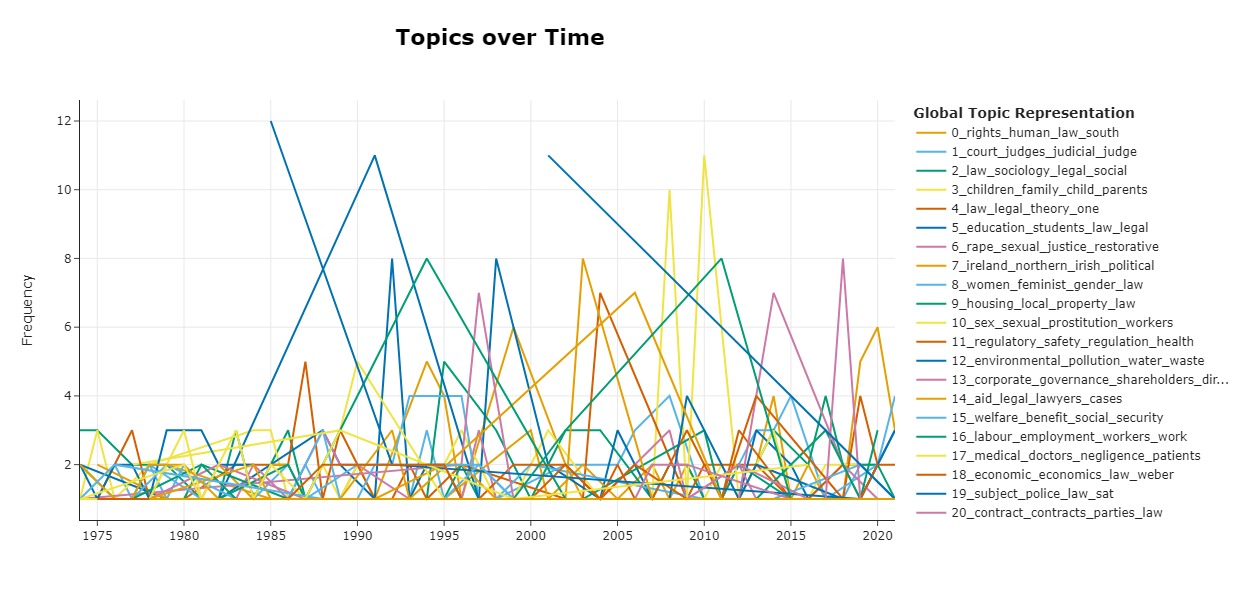

In [13]:
fig = model.visualize_topics_over_time(topics_over_time)
fig.write_html("docs/jls-topics-over-time.html")
img = fig.to_image(format="png", height=600)
with open("figure/jls-topics-over-time.png", "wb") as f:
    f.write(img)
display(Image(img))

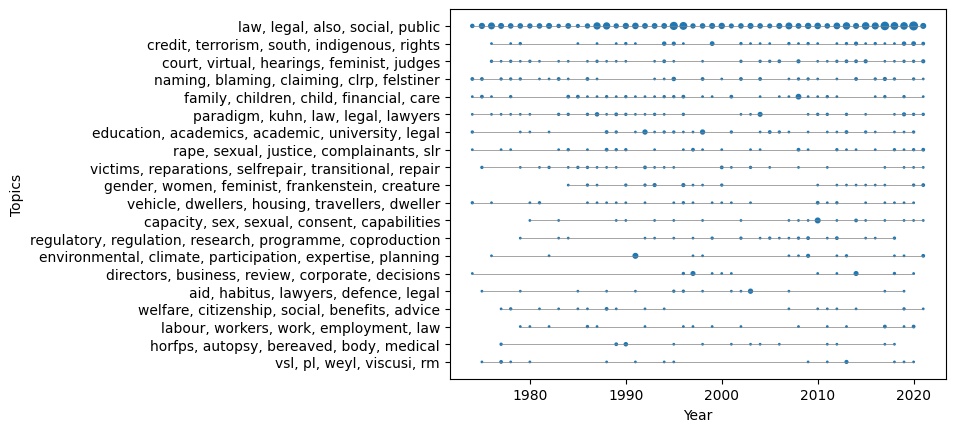

In [14]:
# Calculate total frequency for each topic
total_freq = topics_over_time.groupby('Topic')['Frequency'].sum().sort_values(ascending=False)

# Select the 20 topics with the highest total frequency
top_20_topics = total_freq.head(20).index

# Filter your data to include only these top 20 topics
filtered_data = topics_over_time[topics_over_time['Topic'].isin(top_20_topics)]

# Create a mapping of topics numbers to words using the filtered data
topic_num_to_word = {num: word for num, word in zip(filtered_data['Topic'], filtered_data['Words'])}

# Plot
fig, ax = plt.subplots()
ax.set_xlabel('Year')
ax.set_ylabel('Topics')

scatter = ax.scatter(filtered_data['Timestamp'], filtered_data['Topic'], s=filtered_data['Frequency'])

# Rename y ticks to correspond to actual topics
plt.yticks(top_20_topics, [topic_num_to_word[num] for num in top_20_topics])

# Invert the y-axis so that the topic with the highest total frequency appears at the top
ax.invert_yaxis()

# Create lines for each topic
for t in top_20_topics:
    data = filtered_data[filtered_data['Topic'] == t][['Timestamp', 'Topic']].sort_values('Timestamp')
    ax.plot(data['Timestamp'], data['Topic'], color='grey', linewidth=0.5)

plt.show()


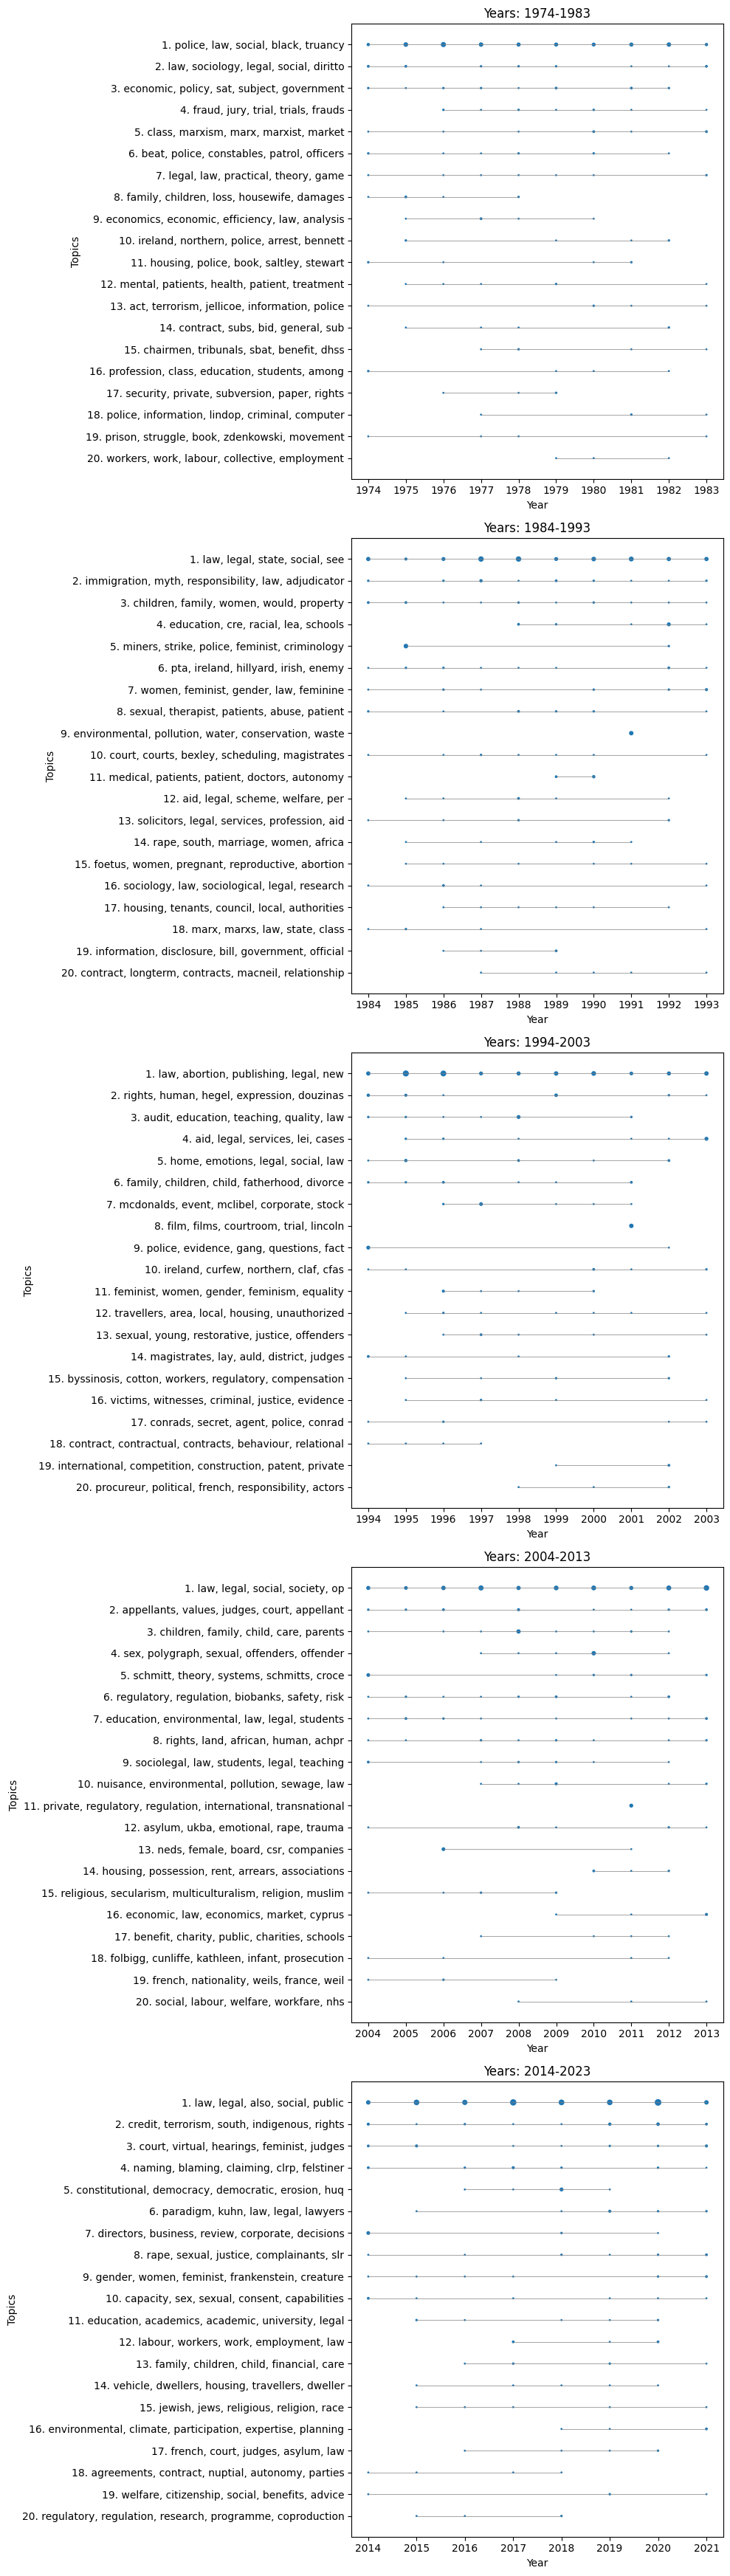

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Convert 'Timestamp' to datetime
topics_over_time['Timestamp'] = pd.to_datetime(topics_over_time['Timestamp'])

# Calculate the year for each row in the data
topics_over_time['Year'] = topics_over_time['Timestamp'].dt.year

# Get the first year and last year
first_year = topics_over_time['Year'].min()
last_year = topics_over_time['Year'].max()

# Create list of "decades" with sliding windows
decades = [(start, start + 10) for start in range(first_year, last_year, 10)]

# Create a subplot for each decade
fig, axs = plt.subplots(len(decades), 1, figsize=(10, 7*len(decades)))

for i, (start, end) in enumerate(decades):
    # Filter the data for the current "decade"
    data_decade = topics_over_time[(topics_over_time['Year'] >= start) & (topics_over_time['Year'] < end)]

    # Calculate total frequency for each topic in the current "decade"
    total_freq_decade = data_decade.groupby('Topic')['Frequency'].sum().sort_values(ascending=False)

    # Select the top 20 topics from the current "decade"
    top_topics_decade = total_freq_decade.head(20).index

    # Filter data_decade to include only the top 20 topics
    data_decade = data_decade[data_decade['Topic'].isin(top_topics_decade)]

    # Create a mapping of topics numbers to words using the data_decade
    topic_num_to_word = {num: word for num, word in zip(data_decade['Topic'], data_decade['Words'])}

    # Create a new continuous range of numbers for y-axis, but in reversed order
    y_values = range(20, 0, -1)
    topic_to_y_value = {topic: y for topic, y in zip(top_topics_decade, y_values)}

    # Plot
    axs[i].set_title(f'Years: {start}-{end-1}')
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Topics')
    scatter = axs[i].scatter(data_decade['Timestamp'], data_decade['Topic'].map(topic_to_y_value), s=data_decade['Frequency'])

    # Rename y ticks to correspond to actual topics
    y_labels = [f'{rank}. {topic_num_to_word[num]}' for rank, num in zip(range(1, 21), top_topics_decade)]
    axs[i].set_yticks(y_values)
    axs[i].set_yticklabels(y_labels)

    # Create lines for each topic
    for t in top_topics_decade:
        data = data_decade[data_decade['Topic'] == t].sort_values('Timestamp')
        axs[i].plot(data['Timestamp'], data['Topic'].map(topic_to_y_value), color='grey', linewidth=0.5)

    # Save the figure
    #filename = f'docs/jls-topics-{start}-{end-1}.png'
    #plt.savefig(filename)
    # Clear the current figure's content
    #plt.clf()

filename = f'docs/jls-topics-{first_year}-{last_year}.png'
plt.savefig(filename)
plt.tight_layout()
plt.show()


In [20]:
# created document topics, this takes a while
fig_document_topics = model.visualize_documents(articles, hide_document_hover=True)
# persist data
with open('cache/fig-document-topics.pkl', 'wb') as f:
    pickle.dump(fig_document_topics, f)

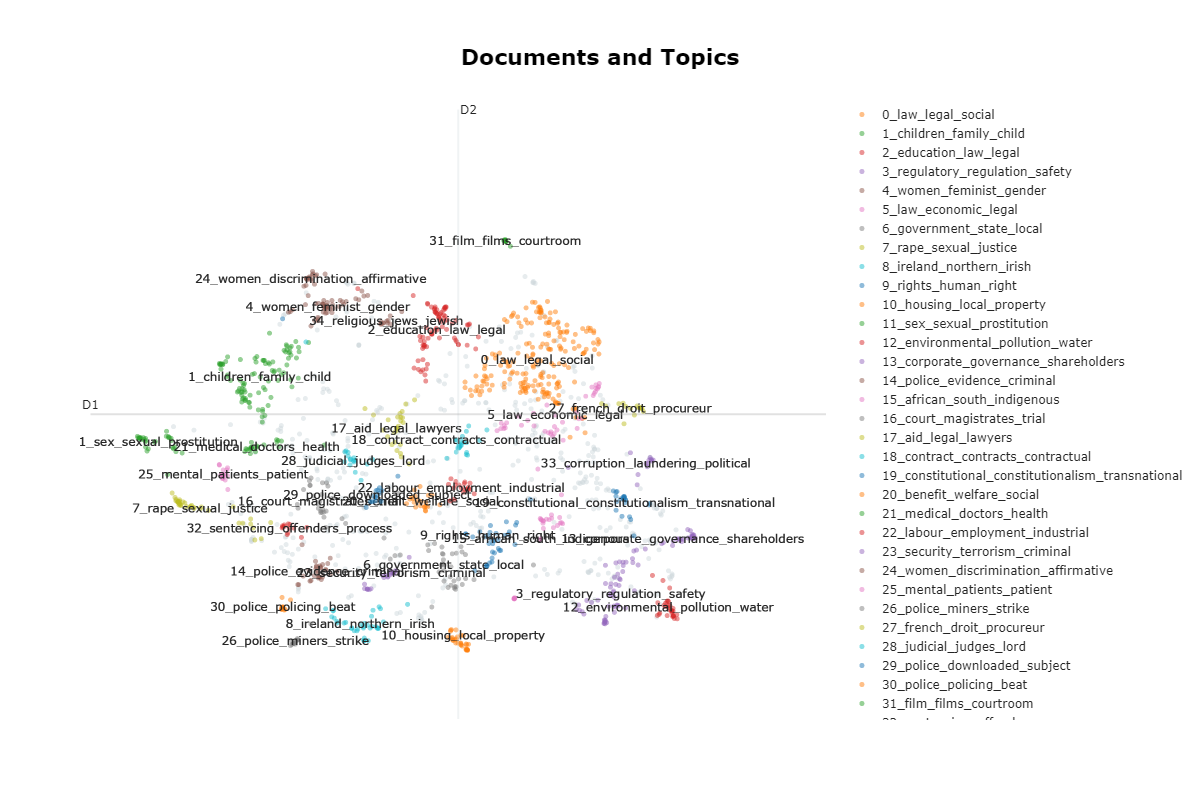

In [21]:
if 'fig_document_topics' not in locals():
    with open('cache/fig-document-topics.pkl', 'rb') as f:
        fig_document_topics = pickle.load(f)
img = fig_document_topics.to_image(format="png", height=800)
with open("figure/jls-document-topics.png", "wb") as f:
    f.write(img)
fig_document_topics.write_html("docs/jls-document-topics.html")
display(Image(img))

In [2]:
from scripts.publish_notebook import save_notebook_as_html
save_notebook_as_html("jls-topic-modelling.ipynb", "docs/notebook-jls-topic-modelling.html")

Notebook saved as HTML: docs/notebook-jls-topic-modelling.html
